# Minimum Daily Temperatures Dataset

This dataset describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.
The units are in degrees Celsius and there are 3650 observations. 
The source of the data is credited as the Australian Bureau of Meteorology.

[Download here](https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv)

# Data Exploration

In [1]:
# Load the Pandas/Numpy libraries with standard aliases
import pandas as pd 
import numpy as np

# Read data from file
df = pd.read_csv("data/daily-min-temperatures.txt") 

# Preview the first 5 lines of the loaded data 
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


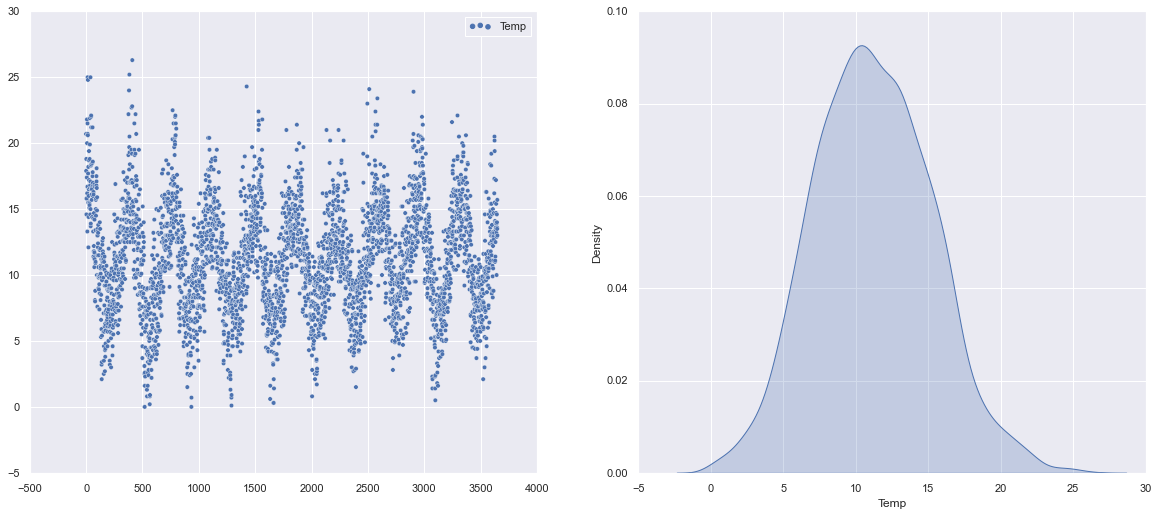

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [15]:
# Load plot packages to show data distribution
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(20,8.27)})

#Plot dataset & distribution
fig, ax =plt.subplots(1,2)
sns.scatterplot(data=df, ax=ax[0])
sns.kdeplot(df['Temp'], shade=True, ax=ax[1])
plt.show()

#Show data stats
df.describe()

# Model training

In [3]:
# Rename columns to meet Prophet input dataframe standards
df.rename(columns={'Date':'ds','Temp':'y'},inplace=True)
# Convert Date column to datetime64 dtype
df['ds']= pd.to_datetime(df['ds'], infer_datetime_format=True)
# Get dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3650 non-null   datetime64[ns]
 1   y       3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


In [4]:
# Load Prophet library & tools
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
import itertools

Importing plotly failed. Interactive plots will not work.


## Hyperparameters tuning with cross validation

In [5]:
# Tune hyperparameters of the model
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 15 forecasts with cutoffs between 1983-02-06 00:00:00 and 1989-12-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8591bae5c0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 15 forecasts with cutoffs between 1983-02-06 00:00:00 and 1989-12-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8591be4a20>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 15 forecasts with cutoffs between 1983-02-06 00:00:00 and 1989-12-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.pro

KeyboardInterrupt: 

In [7]:
# Best params?
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


## Model fitting

In [8]:
# Fit a new model using best params
m = Prophet(**best_params)
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Predict new data

In [9]:
# Prepare dataframe for prediction
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
4010,1991-12-27
4011,1991-12-28
4012,1991-12-29
4013,1991-12-30
4014,1991-12-31


In [10]:
# Predict future values
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4010,1991-12-27,14.474506,10.991541,18.033037
4011,1991-12-28,14.493657,10.999393,18.082936
4012,1991-12-29,14.469692,10.907636,17.863939
4013,1991-12-30,14.663238,11.301323,18.266313
4014,1991-12-31,14.827441,11.568473,18.196905


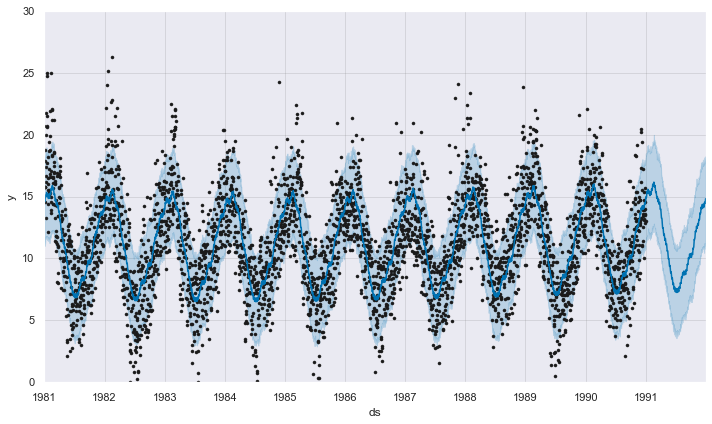

In [11]:
# Display results
fig1 = m.plot(forecast)

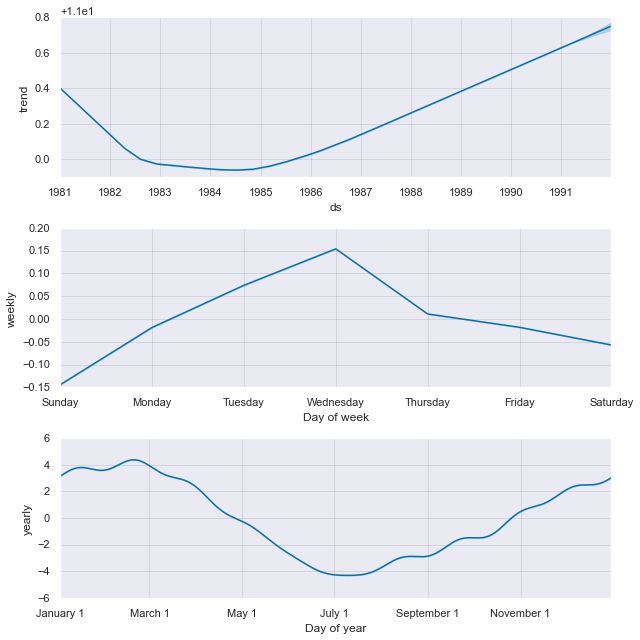

In [12]:
fig2 = m.plot_components(forecast)